In [131]:
import cnn_builder as cbuild
import config
import copy
import glob
import importlib
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.registration as reg
import niftiutils.masks as masks
import numpy as np
import os
import shutil
from os.path import *
%matplotlib inline
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_dilation
from skimage.morphology import ball, label

import numpy as np
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import np_utils

In [110]:
import SimpleITK as sitk
import sys

In [94]:
importlib.reload(hf)
C = config.Config()

In [3]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

## Non-rigid reg

In [132]:
patient_id = "02"

In [134]:
mribl_art_path = join(target_dir, patient_id, "MRI-BL", "t1-art.nii.gz")
mribl_tumor_mask_path = join(target_dir, patient_id, "tumor bl.ids")
ct24_path = join(target_dir, patient_id, "nii_files", "ct24.nii.gz")
ct24_tumor_mask_path = glob.glob(join(target_dir, patient_id, "tumor 24h*.ids"))[0]

In [133]:
ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)

In [135]:
hf.save_nii(ct_img, ct24_path, ct_dims)

In [136]:
img_ref_path = mribl_art_path
mask_ref_path = mribl_tumor_mask_path
img_mov_path = ct24_path
mask_mov_path = ct24_tumor_mask_path

In [137]:
def crop_nonzero(arr, crops=None):
    if crops is None:
        nonzeros = np.argwhere(arr)
        crops1 = nonzeros.min(axis=0)
        crops2 = nonzeros.max(axis=0)
    else:
        crops1, crops2 = crops
        
    return arr[crops1[0]:crops2[0]+1,
              crops1[1]:crops2[1]+1,
              crops1[2]:crops2[2]+1], (crops1, crops2)

In [156]:
img_r, img_r_dims = hf.nii_load(img_ref_path)
mask_r, mask_r_dims = masks.get_mask(mask_ref_path, img_r_dims, img_r.shape)

img_m, img_m_dims = hf.nii_load(img_mov_path)
mask_m, mask_m_dims = masks.get_mask(mask_mov_path, img_m_dims, img_m.shape)

mask_r, crops_r = crop_nonzero(mask_r)
img_r, _ = crop_nonzero(img_r, crops_r)
img_r[mask_r == 0] = 0

mask_m, crops_m = crop_nonzero(mask_m)
img_m, _ = crop_nonzero(img_m, crops_m)
img_m[mask_m == 0] = 0

R = 1.5
mask_r_iso, _ = tr.rescale_img(mask_r, [R]*3, mask_r_dims)
img_r_iso, _ = tr.rescale_img(img_r, [R]*3, img_r_dims)
mask_m_iso, _ = tr.rescale_img(mask_m, [R]*3, mask_m_dims)
img_m_iso, _ = tr.rescale_img(img_m, [R]*3, img_m_dims)

In [144]:
mask_r_iso.shape

(10, 10, 13)

In [149]:
img_m_iso.shape

(34, 29, 37)

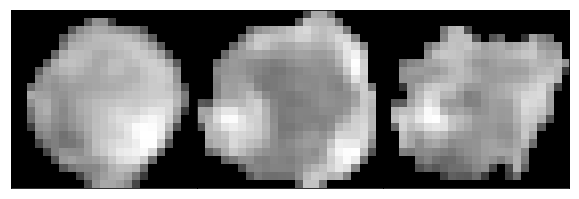

In [157]:
hf.draw_slices(img_r_iso)

In [138]:
def reg_masks(mask_ref_path, img_ref_path, mask_mov_path, img_mov_path):
    img_r, img_r_dims = hf.nii_load(img_ref_path)
    mask_r, mask_r_dims = masks.get_mask(mask_ref_path, img_r_dims, img_r.shape)
    
    img_m, img_m_dims = hf.nii_load(img_mov_path)
    mask_m, mask_m_dims = masks.get_mask(mask_mov_path, img_m_dims, img_m.shape)
    
    mask_r, crops_r = crop_nonzero(mask_r)
    img_r, _ = crop_nonzero(img_r, crops_r)
    img_r[mask_r == 0] = 0
    
    mask_m, crops_m = crop_nonzero(mask_m)
    img_m, _ = crop_nonzero(img_m, crops_m)
    img_m[mask_m == 0] = 0
    
    R = 1.5
    mask_r_iso = tr.rescale_img(mask_r, [R]*3, mask_r_dims)
    img_r_iso = tr.rescale_img(img_r, [R]*3, img_r_dims)
    mask_m_iso = tr.rescale_img(mask_m, [R]*3, mask_m_dims)
    img_m_iso = tr.rescale_img(img_m, [R]*3, img_m_dims)
    
    _, xform = reg.reg_nonrigid(mask_r_iso, mask_m_iso)
    
    img_m_reg = transform(xform, img_m_iso)
    
    return xform, crops_m, img_r_iso, img_m_reg

In [ ]:
mribl_ct24_xform, ct24_tumor, mribl_tumor, mribl_ct24_crops = reg_masks(ct24_tumor_mask_path, ct24_path, mribl_tumor_mask_path, mribl_art_path)

In [ ]:
def transform_mask(mask_path, img_path, xform, crops):
    img, img_dims = hf.nii_load(img_path)
    mask, mask_dims = masks.get_mask(mask_path, img_dims, img.shape)
    
    mask, _ = crop_nonzero(mask, crops)
    R = 1.5
    mask_iso = tr.rescale_img(mask, [R]*3, mask_dims)
    xform_mask = reg.reg_nonrigid(mask_iso, xform)
    
    return xform_mask

In [ ]:
mribl_enh_mask_path = join()

In [ ]:
mribl_enh_mask_ct24 = transform_mask(mribl_enh_mask_path, mribl_art_path, mribl_ct24_xform, mribl_ct24_crops)

In [ ]:
mribl_enh_mask_ct24

In [ ]:
# BL MRI to 24h CT
vec_field = lm.reg_masks(ct_tumor_mask_path, blmri_tumor_mask_path)

In [ ]:
mribl_enh_mask = reg.apply_field(vec_field)

In [ ]:
ct24_lip = lm.seg_lipiodol()

In [ ]:
def 

In [ ]:
reg.reg_sitk(ct24_lip, vec_field)

### MRI loading

In [114]:
mri_dcm_paths = [x for x in glob.glob(join(target_dir, '*', 'MRI-BL', '*20s*')) if '.nii' not in x]
mri_dcm_paths

In [ ]:
patient_id = "02"
dcm_paths = [x for x in glob.glob(join(target_dir, patient_id, "MRI-BL","*")) if x.find('.')==-1]
for dcm_path in dcm_paths:
    if not exists(splitext(dcm_path)[0] + ".nii.gz"):
        try:
            save_path = splitext(dcm_path)[0] + ".nii.gz"
            img, dims = hf.dcm_load(dcm_path, True, True)
            hf.save_nii(img, save_path, dims)
        except:
            print(dcm_path)

In [119]:
art_paths = [x for x in glob.glob(join(target_dir, patient_id, "MRI-BL","*.nii.gz")) if '20s' in x or 'Ph1-Ax' in x]
for path in art_paths:
    os.rename(path, join(dirname(path), "t1-art.nii.gz"))

In [ ]:
path_dict = {}
patient_id = '04'
for path in glob.glob(join(target_dir, patient_id, "MRI-BL","*","*")):
    header = hf.dcm_load_header(path)
    if len(header) > 0:
        series_descript = header[0][('0008', '103e')].value
        path_dict[path] = series_descript
        series_descript = series_descript.replace("/","-")
        os.rename(path, join(target_dir,patient_id, "MRI-BL", series_descript))

### Bias field corr

In [122]:
mri_raw_paths = glob.glob(join(target_dir, '*', 'MRI-BL', 't1-art.nii.gz'))
mri_bfc_paths = [join(dirname(x), "t1-art-bfc.nii.gz") for x in mri_raw_paths]

In [130]:
importlib.reload(masks)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [ ]:
glob.glob(join(target_dir, patient_id, ''

In [ ]:
masks.mask2nii()

In [128]:
inputImage = sitk.ReadImage(mri_raw_paths[0])
maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )

if len ( sys.argv ) > 3:
    inputImage = sitk.Shrink( inputImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )
    maskImage = sitk.Shrink( maskImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )

inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )

corrector = sitk.N4BiasFieldCorrectionImageFilter()

numberFilltingLevels = 4
#corrector.SetMaximumNumberOfIterations( [ int( sys.argv[5] ) ] *numberFilltingLevels  )

output = corrector.Execute( inputImage, maskImage )

sitk.WriteImage( output, mri_bfc_paths[0] )

### Masks

## Lipiodol seg

In [82]:
importlib.reload(lm)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [102]:
# Lipiodol 3 masks
info = {}
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    break

In [ ]:
# Lipiodol target vs non-target masks
info = {}
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_target_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    #break